In [2]:
import os, pathlib, sys
from fnmatch import fnmatch
import re
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

---
# Calculating User Overlap Matrix for Mental Health Communties on Reddit.
---

In [4]:
df = pd.read_csv("../data/submissions_preprocessed_reduced.csv.zip", index_col=0)

In [5]:
df

,author,created_utc,permalink,selftext,subreddit
0,jrizos,1.314204e+09,/r/addiction/comments/jt0n7/a_family_member_ha...,This person has been using for roughly 10 year...,addiction
1,FlashGameAddict,1.325585e+09,/r/addiction/comments/o0y5w/im_quitting_online...,I'm addicted to online games. Most recently I'...,addiction
2,themarknessmonster,1.327220e+09,/r/addiction/comments/or9wd/is_it_possible_for...,"I think I might be addicted to light, or, more...",addiction
3,jmc726,1.333120e+09,/r/addiction/comments/rl03q/tramodol_abuse_any...,"For anyone not familiar with Tramadol, it's a ...",addiction
4,PetiePal,1.334265e+09,/r/addiction/comments/s6swk/my_friend_is_becom...,Hey guys. I've got a friend who recently came ...,addiction
...,...,...,...,...,...
1579814,throw_away_the_panda,1.624366e+09,/r/SelfHate/comments/o5meab/i_genuinely_try_an...,I'm sat at my desk again and I'm unable to kee...,SelfHate
1579815,twisted-spirit,1.624496e+09,/r/SelfHate/comments/o6pzta/i_feel_like_i_dont...,"The more I try to make friends, or pretend I'm...",SelfHate
1579816,DedKulak1917,1.624593e+09,/r/SelfHate/comments/o7ft41/really_not_a_fan_o...,Recently cheated on my fiancé. We are in the p...,SelfHate
1579817,edensrotting,1.624981e+09,/r/SelfHate/comments/oaall2/another_person_her...,"I'm a self destructive person and honestly, i ...",SelfHate


In [6]:
# -------------------------------------------------
# Similarity Matrix
# -------------------------------------------------
def calc_similairties(df, content, save_path):
    vectorizer = TfidfVectorizer()
    doc_term_matrix = vectorizer.fit_transform(content)
    cosine_sim_matrix = cosine_similarity(doc_term_matrix)
    plt.figure(figsize=(70,60))
    # invert the the values. quick hack
    sns.heatmap(1 - cosine_sim_matrix, annot=True, cmap="rocket",square=True, linewidth=.5, xticklabels=df['subreddit'], yticklabels=df['subreddit'])
    plt.xticks(rotation=75)
    plt.savefig(save_path)
    plt.show()

def combine_strings(df):
    columns = ['subreddit', 'user', 'size']
    data = pd.DataFrame(columns=columns)
    for index, subreddit in enumerate(df['subreddit']):
        temp_subs = df[df['subreddit']==subreddit]
        users = ""
        for list in temp_subs['user']:
            for user in list:
                users = str(users) + str(user)
        size = len(users)
        new_row = {'subreddit': subreddit, 'user': users, 'size': size}
        data.loc[len(data.index)] = new_row
    return data

def transform_list_to_string(df):
    df['user'].apply(', '.join)
    return df

# ----------------------------------------------------------
# Create a list of strings (content) needed for
# TfidfVectorizer().fit_transform. list("", "", "",..)
# each string representing a columnelement/row/list of users
# ----------------------------------------------------------
def create_content(df):
    content = []
    for list in df['user']:
        new_content = ''
        for i, string in enumerate(list):
            # print("i: " + str(i) + "| len(list): " + str(len(list)))
            if i < (len(list) - 1):
                new_content = new_content + str(string) + ' '
            else:
                new_content = new_content + str(string)
        content.append(new_content)
    return content

# --------------------------------------------------
# Debugging for checking Similarity
# --------------------------------------------------
def intersection(list1, list2):
    intersection = list()
    for item in list1:
        if item in list2:
            intersection.append(item)
    return intersection

# -------------------------------------------------
# User Overlap Matrix - Needed for Overlap
# -------------------------------------------------
def create_overlap_data(df,subreddits):
    columns = ['subreddit', 'user']
    overlap_df = pd.DataFrame(columns=columns)
    for sub in subreddits:
        users = list()
        users.extend(df[(df['subreddit'] == sub)]['author'])
        # removes duplicates and maintains order.
        new_row = {'subreddit': sub, 'user': users}
        overlap_df.loc[len(overlap_df.index)] = new_row
    return overlap_df.reset_index(drop=True)

# -------------------------------------------------
# Add Counter for Debugging
# -------------------------------------------------
def add_count(df):
    lists = df['user']
    column_name = 'user_count'
    user_count = []
    for list in lists:
        user_count.append(len(list))
    df[column_name] = user_count
    return df

# --------------------------------------------------
#  Overlap Calculation - Percentage
# --------------------------------------------------
def calc_overlap(df):
    overlap_matrix = []
    for i, row in df.iterrows():
        overlap_row = []
        for j, row_j in df.iterrows():
            users_i = set(row['user'])
            users_j = set(row_j['user'])
            overlap_row.append(len(users_i & users_j) / len(users_i))
        overlap_matrix.append(overlap_row)
    df_overlap_matrix = pd.DataFrame(overlap_matrix, columns=df.subreddit.values)
    df_overlap_matrix.index = df.subreddit.values
    np.fill_diagonal(df_overlap_matrix.values, 1)
    return df_overlap_matrix

# --------------------------------------------------
#  Overlap Calculation - Percentage
# --------------------------------------------------
def calc_overlap_new(df):
    overlap_matrix = []
    for i, row in df.iterrows():
        overlap_row = []
        for j, row_j in df.iterrows():
            # remove duplicates
            temp_i = dict.fromkeys(row['user'])    
            users_i = list(temp_i)
            temp_j = dict.fromkeys(row_j['user'])
            users_j = list(temp_j)
            
            overlap_row.append(len(intersection(users_i, users_j)) / len(users_i))
        overlap_matrix.append(overlap_row)
    df_overlap_matrix = pd.DataFrame(overlap_matrix, columns=df.subreddit.values)
    df_overlap_matrix.index = df.subreddit.values
    np.fill_diagonal(df_overlap_matrix.values, 1)
    return df_overlap_matrix

    
# --------------------------------------------------
# Overlap Visualization - wiht saving
# With Viz Hack - Distance Matrix
# --------------------------------------------------
def viz_overlap(df, save_path):
    plt.figure(figsize=(70,60))
    # invert the the values. quick hack
    sns.heatmap(1 - df.values, annot=True, cmap="rocket",square=True, linewidth=.5,
                xticklabels=df.columns, yticklabels=df.index)
    plt.xticks(rotation=75)
    plt.savefig(save_path)
    plt.show()

# --------------------------------------------------
# Overlap Visualization - without saving
# With Viz Hack - Distance Matrix
# --------------------------------------------------
def viz_overlap(df):
    plt.figure(figsize=(70,60))
    # invert the the values. quick hack
    sns.heatmap(1 - df.values, annot=True, cmap="rocket",square=True, linewidth=.5,
                xticklabels=df.columns, yticklabels=df.index)
    plt.xticks(rotation=75)
    plt.show()

In [7]:
list_subreddits = df['subreddit'].unique()
overlap = create_overlap_data(df, list_subreddits)
overlap = add_count(overlap)
overlap.reset_index(drop=True)

,subreddit,user,user_count
0,addiction,"[jrizos, FlashGameAddict, themarknessmonster, ...",7083
1,SMARTRecovery,"[gogojack, Creative1963, Oranges13, emilyfg, e...",125
2,AtheistTwelveSteppers,"[socksynotgoogleable, socksynotgoogleable, J_C...",222
3,secularsobriety,"[makesureimjewish, yellownumberfive, nomadicto...",41
4,recovery,"[amylong1933, fromnothingness, foreverawakeat4...",1058
...,...,...,...
83,MMFB,"[TheShadowFog, beermethestrength, probly2drunk...",5409
84,bulimia,"[shalalalalabumba, Ginger803, needtograduate16...",4352
85,BodyDysmorphia,"[Ooozu, ButtercupButterflies, littlecrystalgir...",4708
86,BodyAcceptance,"[pandabritt, funkengruven88, aliaras, littlegr...",908


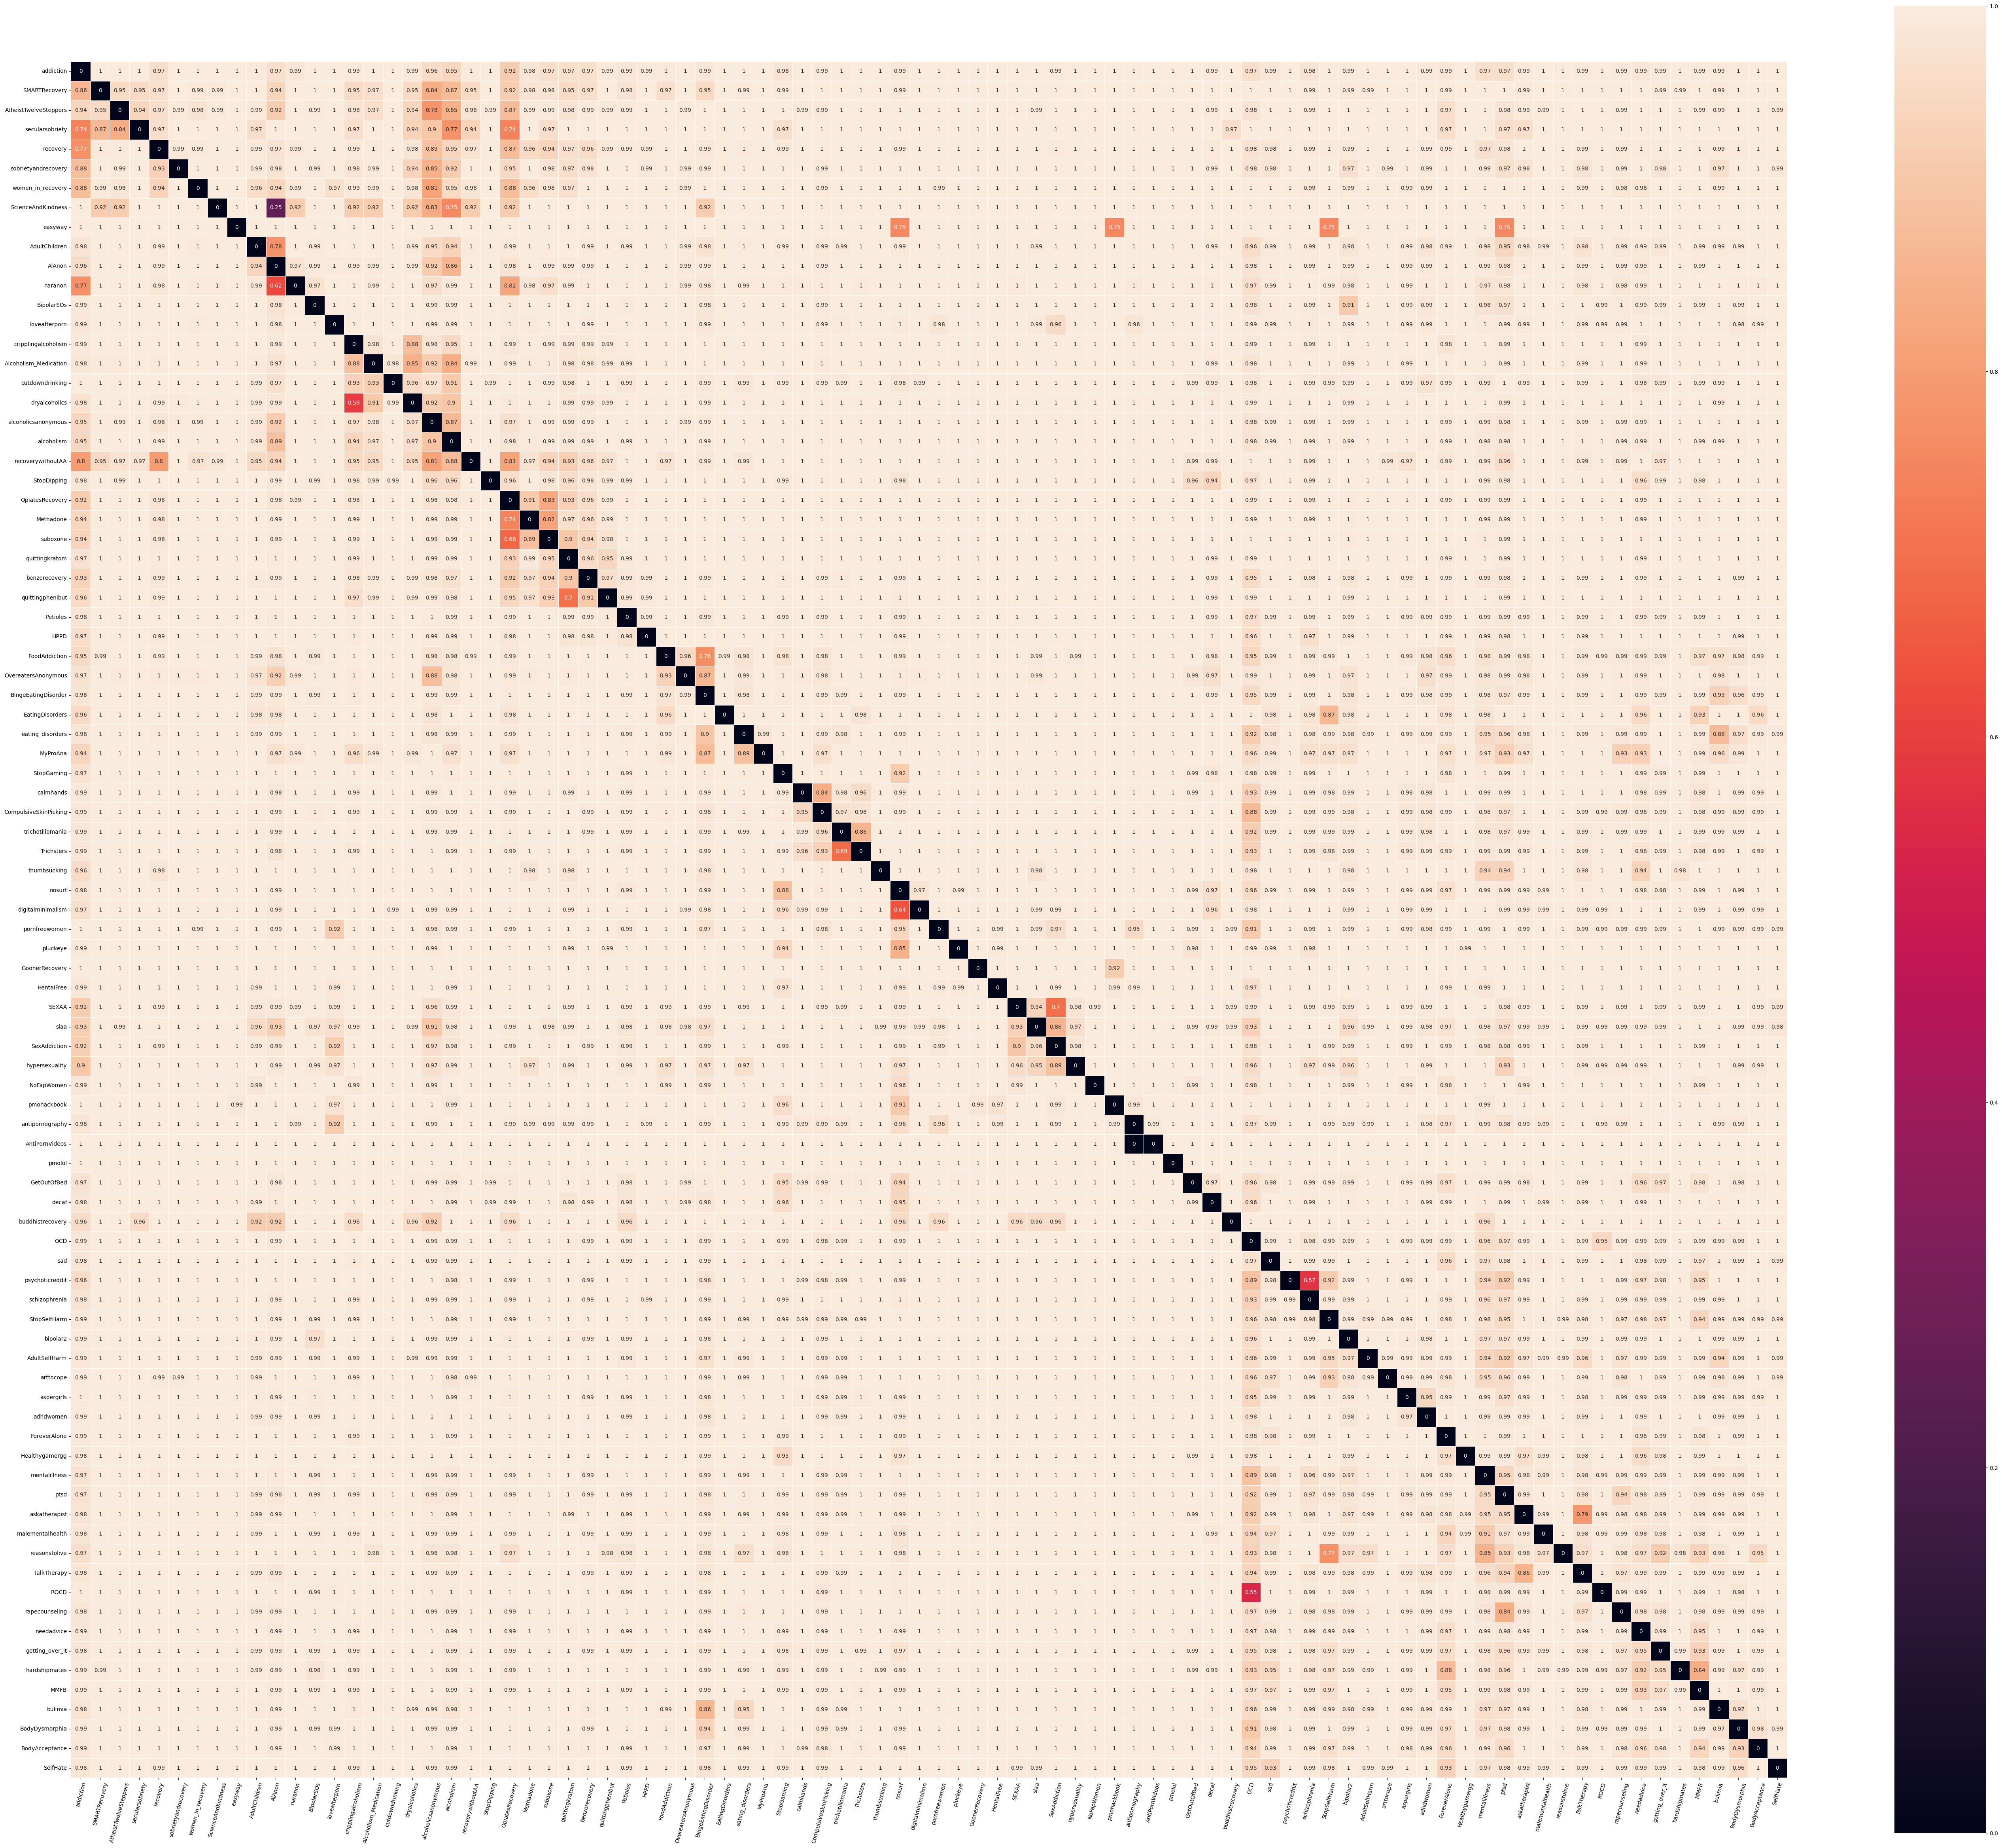

In [8]:
result = calc_overlap(overlap)
result_matrix = result
viz_overlap(result_matrix)

---
# Overlap with Unique Users
---

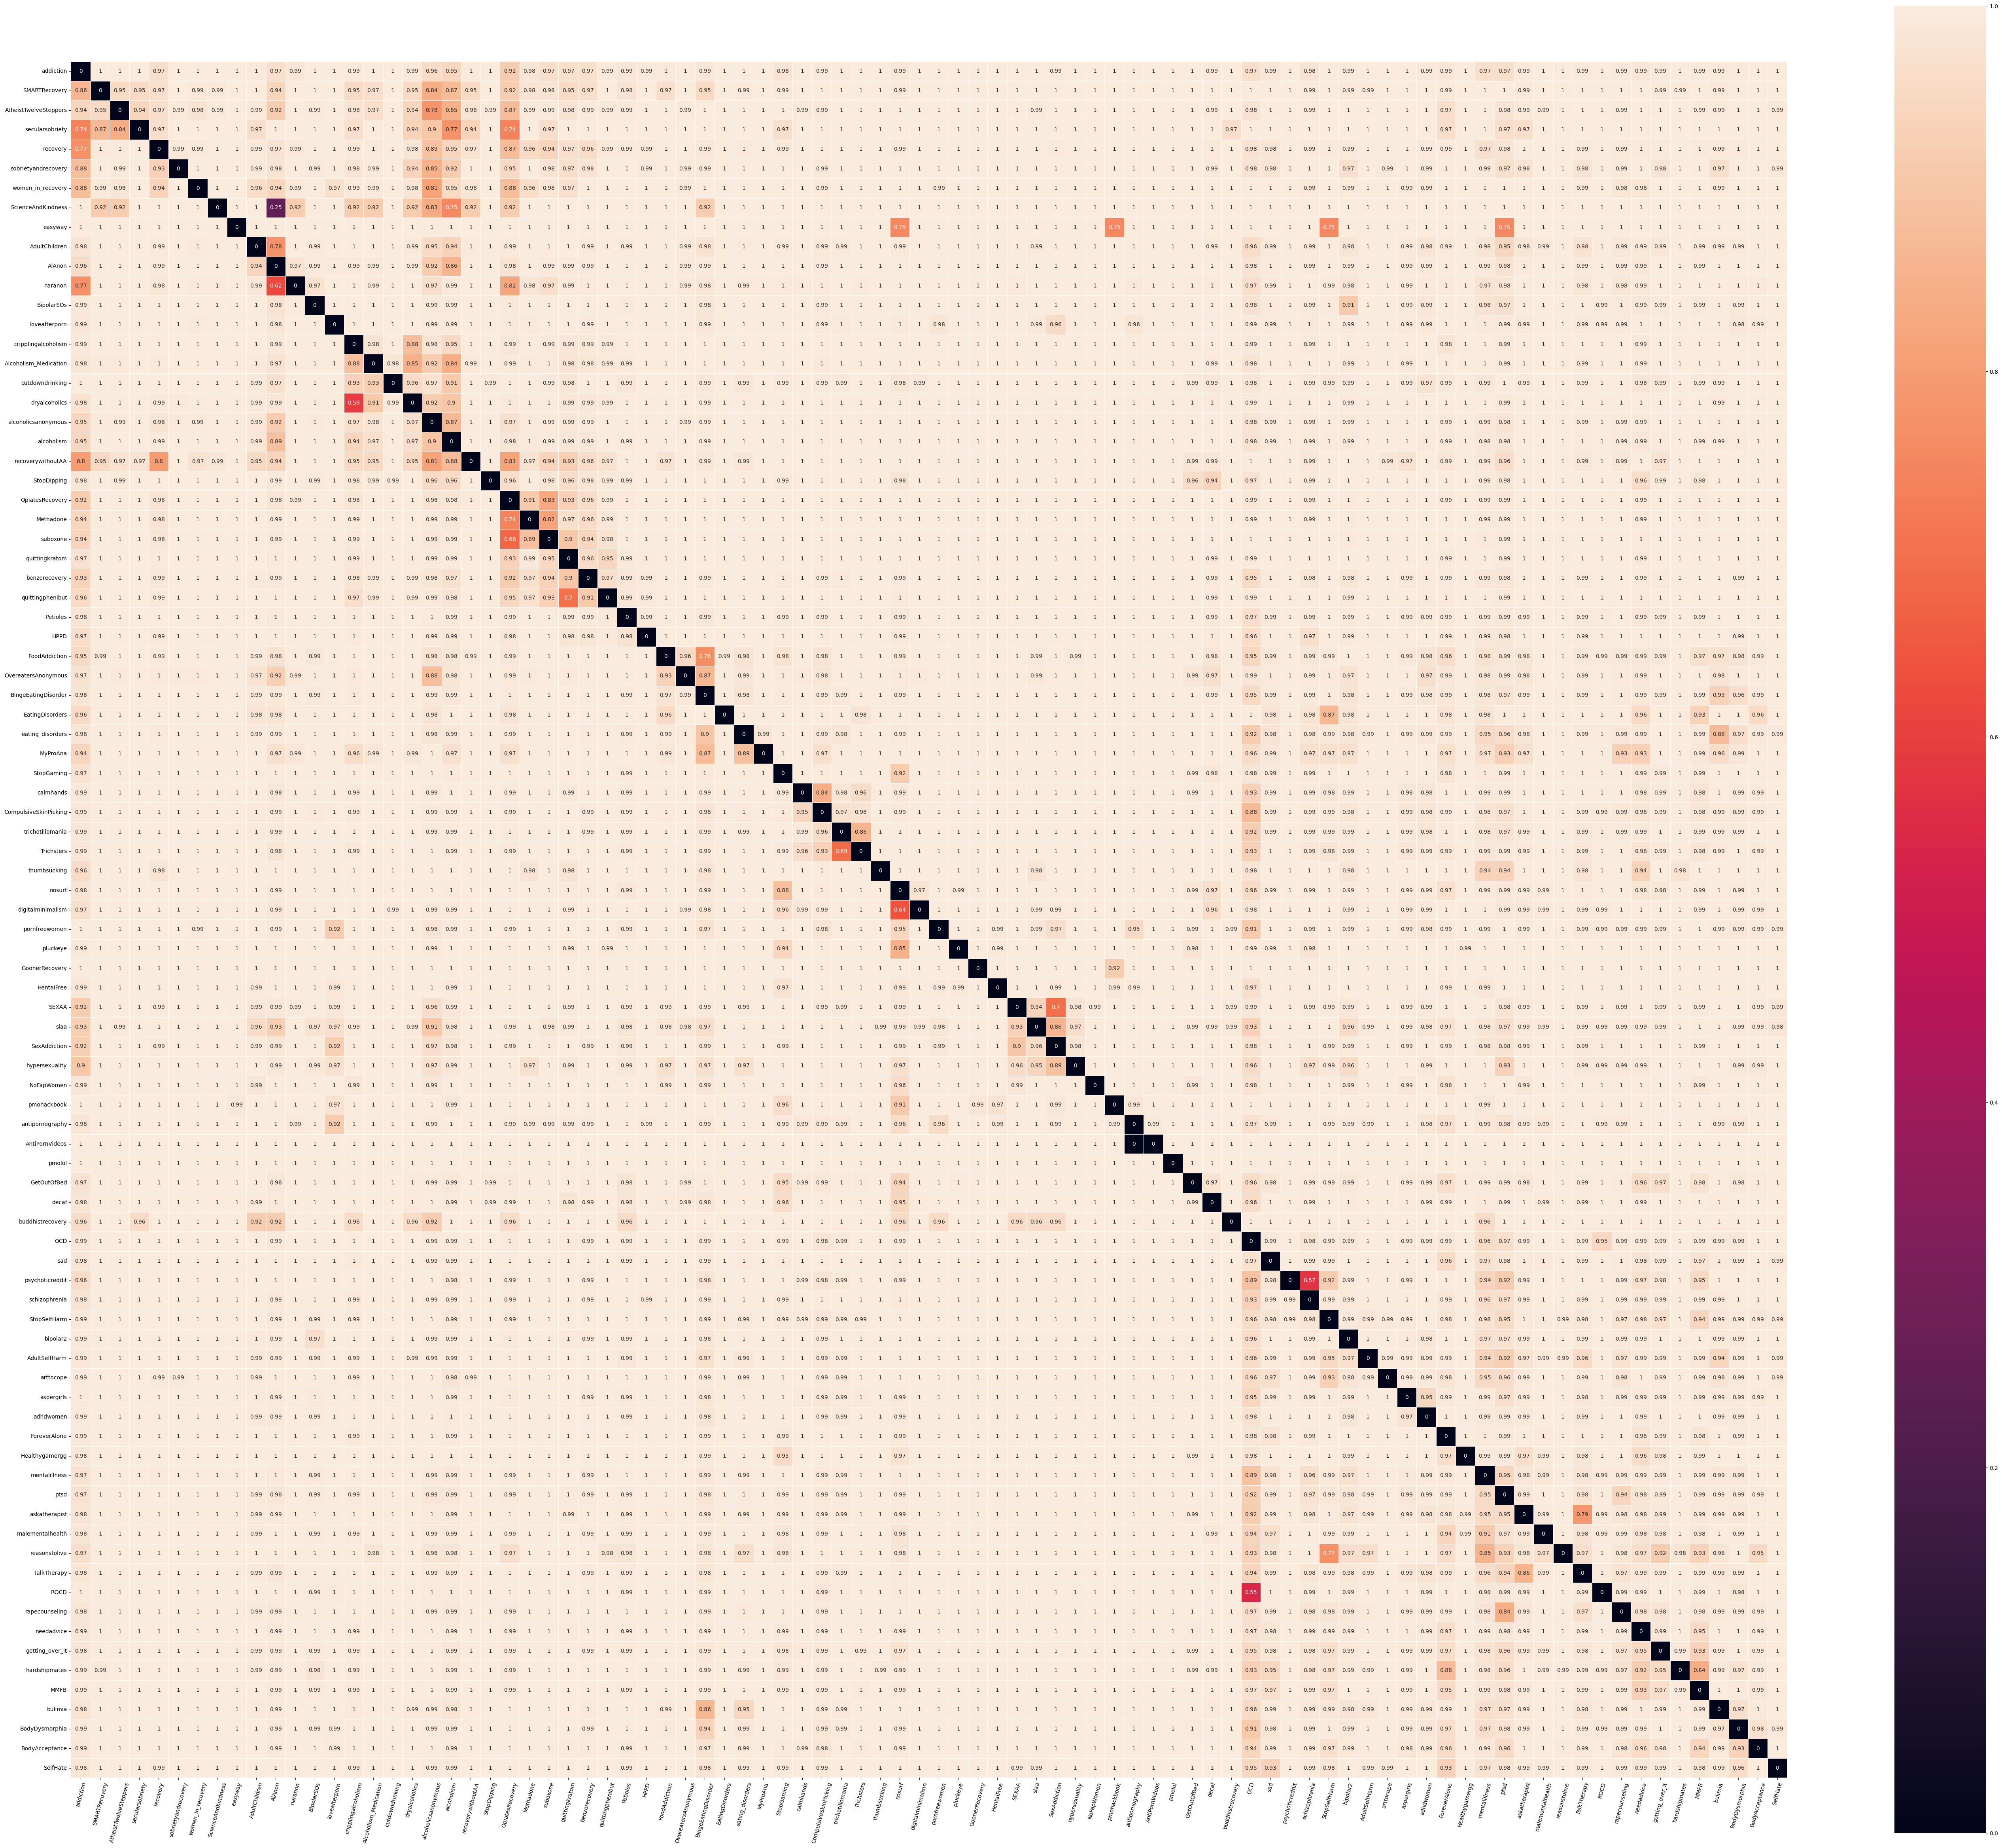

In [9]:
result = calc_overlap_new(overlap)
result_matrix = result
viz_overlap(result_matrix)

save_path = pathlib.Path('../data/UserOverlapData.json')
result_matrix.to_json(save_path)

In [10]:
result_matrix

,addiction,SMARTRecovery,AtheistTwelveSteppers,secularsobriety,recovery,sobrietyandrecovery,women_in_recovery,ScienceAndKindness,easyway,AdultChildren,...,ROCD,rapecounseling,needadvice,getting_over_it,hardshipmates,MMFB,bulimia,BodyDysmorphia,BodyAcceptance,SelfHate
addiction,1.000000,0.003035,0.001265,0.002023,0.034648,0.003035,0.003288,0.000000,0.0,0.004299,...,0.001517,0.007587,0.013657,0.005311,0.000253,0.006323,0.008346,0.004805,0.002023,0.001517
SMARTRecovery,0.137931,1.000000,0.045977,0.045977,0.034483,0.000000,0.011494,0.011494,0.0,0.000000,...,0.000000,0.000000,0.000000,0.011494,0.011494,0.000000,0.011494,0.000000,0.000000,0.000000
AtheistTwelveSteppers,0.058140,0.046512,1.000000,0.058140,0.034884,0.011628,0.023256,0.011628,0.0,0.011628,...,0.000000,0.011628,0.000000,0.000000,0.000000,0.011628,0.011628,0.000000,0.000000,0.011628
secularsobriety,0.258065,0.129032,0.161290,1.000000,0.032258,0.000000,0.000000,0.000000,0.0,0.032258,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
recovery,0.227953,0.004992,0.004992,0.001664,1.000000,0.011647,0.011647,0.000000,0.0,0.008319,...,0.000000,0.011647,0.004992,0.004992,0.000000,0.004992,0.008319,0.004992,0.000000,0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMFB,0.008775,0.000000,0.000351,0.000000,0.001053,0.000000,0.000000,0.000000,0.0,0.002106,...,0.003510,0.011232,0.073710,0.032643,0.008424,1.000000,0.003510,0.004212,0.012285,0.002106
bulimia,0.021654,0.000656,0.000656,0.000000,0.003281,0.001969,0.000656,0.000000,0.0,0.004593,...,0.003937,0.010499,0.003937,0.005249,0.000656,0.006562,1.000000,0.028215,0.004593,0.002625
BodyDysmorphia,0.011256,0.000000,0.000000,0.000000,0.001777,0.000000,0.000000,0.000000,0.0,0.003555,...,0.012441,0.007109,0.007701,0.002962,0.002370,0.007109,0.025474,1.000000,0.024289,0.007701
BodyAcceptance,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001603,...,0.001603,0.020833,0.043269,0.017628,0.001603,0.056090,0.011218,0.065705,1.000000,0.000000
